In [1]:
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import json
import os
import rasterio
import numpy as np


C:\Users\thoma\AppData\Roaming\Python\Python38\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## cut raster

In [2]:
gdf = gpd.read_file('../konverto_data_package/polygons/polygons.geojson')

In [3]:
gdf

,type,geometry
0,winery,GEOMETRYCOLLECTION EMPTY
1,winery,"MULTIPOLYGON (((675007.413 5143326.011, 675067..."
2,winery,"MULTIPOLYGON (((675066.550 5143267.678, 675149..."
3,winery,"MULTIPOLYGON (((674760.935 5143198.037, 674834..."
4,winery,"MULTIPOLYGON (((673672.158 5143505.380, 673678..."
...,...,...
96,apple orchard,"MULTIPOLYGON (((673977.481 5136172.898, 674005..."
97,winery,"MULTIPOLYGON (((673322.831 5136427.445, 673328..."
98,winery,"MULTIPOLYGON (((672685.775 5139609.934, 672709..."
99,apple orchard,"MULTIPOLYGON (((678006.627 5145427.665, 677996..."


In [4]:
gdf1 = gdf.loc[11]
gdf1

c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\pandas\core\dtypes\inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\pandas\core\dtypes\inference.py:392: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
c

type                                                   winery
geometry    (POLYGON ((673161.0209203674 5138097.815334325...
Name: 11, dtype: object

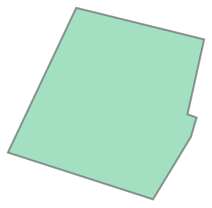

In [5]:
gdf.loc[8].geometry
    

In [6]:
dataset = rasterio.open('../konverto_data_package/climate/tmean/tmean_2020_01_21.tif')
dataset

<open DatasetReader name='../konverto_data_package/climate/tmean/tmean_2020_01_21.tif' mode='r'>

In [7]:
out, inside  = mask(dataset, gdf1[['geometry']], crop=True, invert=False, all_touched=True, nodata=np.nan)
out

array([[[       nan, 0.9553406 ],
        [0.88942724, 0.7424053 ],
        [0.8325057 , 0.34043524]]], dtype=float32)

In [8]:
def get_datasets():

    directory = "../konverto_data_package"
    
    datasets = {}
    for root, dirs, files in os.walk(directory):
        # print(f"Current directory: {root}")
        if "visual" in root:
            continue

        tif_files = [f for f in files if f.endswith(".tif") and not f.startswith(".")]
        tif_paths = [os.path.join(root, f) for f in tif_files]


        if len(tif_files) > 0:

            if "climate" in tif_paths[0]:
                dates = ["-".join(f.replace(".tif", "").split("_")[1:]) for f in tif_files]
            elif "satellite" in tif_paths[0]:
                datestrings = [f.replace(".tif", "").split("_")[0] for f in tif_files]
                dates = [d[:4] + "-" + d[4:6] + "-" + d[6:] for d in datestrings]
            else:
                dates = None
            

            if dates:
                dataset_name = os.path.basename(root)
                
                for date, fp in zip(dates, tif_paths):
                    if date in datasets:
                        datasets[date].update({dataset_name: fp})
                    else:
                        datasets[date] = {dataset_name: fp}
            
            if "terrain" in tif_paths[0]:
                dataset_names = [n.replace(".tif", "") for n in tif_files]
                for date in datasets.keys():
                    for dn, fp in zip(dataset_names, tif_paths):
                        datasets[date].update({dn: fp})

                    


    return datasets

In [9]:
datasets = get_datasets()

In [10]:
datasets["2020-03-22"]

{'gdd': '../konverto_data_package\\climate\\gdd\\gdd_2020_03_22.tif',
 'pmm': '../konverto_data_package\\climate\\pmm\\pmm_2020_03_22.tif',
 'tmax': '../konverto_data_package\\climate\\tmax\\tmax_2020_03_22.tif',
 'tmean': '../konverto_data_package\\climate\\tmean\\tmean_2020_03_22.tif',
 'tmin': '../konverto_data_package\\climate\\tmin\\tmin_2020_03_22.tif',
 'ndvi': '../konverto_data_package\\satellite\\indices\\ndvi\\20200322_ndvi.tif',
 'ndwi': '../konverto_data_package\\satellite\\indices\\ndwi\\20200322_ndwi.tif',
 'reci': '../konverto_data_package\\satellite\\indices\\reci\\20200322_reci.tif',
 'elevation': '../konverto_data_package\\terrain\\elevation.tif',
 'exposure': '../konverto_data_package\\terrain\\exposure.tif',
 'slope': '../konverto_data_package\\terrain\\slope.tif'}

In [11]:
def extract_raster_data_from_polygon(polygon, date_string = "2020-03-22"):

    dataset_paths = get_datasets()
    mean = {}
    std = {}
    for dataset_name, fpath in dataset_paths[date_string].items():
        dataset = rasterio.open(fpath)
        mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
        std[dataset_name] = np.nanstd(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])

    return mean, std

In [12]:
data_2020_03_22 = extract_raster_data_from_polygon(gdf.loc[8][['geometry']], "2020-03-22")

In [13]:
mean__2020_03_22, std_2020_03_22 = data_2020_03_22

In [14]:
mean__2020_03_22

{'gdd': 3.0514283,
 'pmm': 0.5240816,
 'tmax': 18.79458,
 'tmean': 12.797966,
 'tmin': 7.3100734,
 'ndvi': 0.200307,
 'ndwi': -0.0628448,
 'reci': 0.5023746,
 'elevation': 234.68951,
 'exposure': 117.24225,
 'slope': 13.417278}

In [15]:
std_2020_03_22

{'gdd': 0.07790624,
 'pmm': 0.00042274912,
 'tmax': 0.10280419,
 'tmean': 0.067894556,
 'tmin': 0.065944,
 'ndvi': 0.019187992,
 'ndwi': 0.014411566,
 'reci': 0.05902372,
 'elevation': 5.725454,
 'exposure': 7.238578,
 'slope': 3.045035}

In [16]:
dti = pd.date_range("2020-01-01", end="2022-12-31", freq="D")
rows = []
for d in dti:
    try:
        row = extract_raster_data_from_polygon(gdf.loc[8][['geometry']],d.strftime("%Y-%m-%d"))[0]
    except:
        print(d)
    rows.append(row)
ts = pd.DataFrame(index=dti,data=rows)



C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2020-08-19 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2020-11-05 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2020-12-13 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2021-04-17 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2021-07-03 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2021-08-01 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2021-09-09 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2021-11-25 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2022-02-24 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2022-05-01 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2022-05-12 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2022-06-16 00:00:00
2022-06-28 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2022-07-27 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2022-10-06 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

2022-11-09 00:00:00


C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
c:\Users\thoma\.conda\envs\RealTimeBigData\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\thoma\AppData\Local\Temp\ipykernel_19208\2538390866.py:8: RuntimeWarning: Mean of empty slice
  mean[dataset_name] = np.nanmean(mask(da

In [18]:
ts.head()

,gdd,pmm,tmax,tmean,tmin,elevation,exposure,slope,ndvi,ndwi,reci
2020-01-01,0.0,0.0,9.328818,3.369512,-1.716405,234.689514,117.242249,13.417278,NaN,NaN,NaN
2020-01-02,0.0,0.0,6.614949,2.269915,-3.092739,234.689514,117.242249,13.417278,NaN,NaN,NaN
2020-01-03,0.0,0.0,5.042021,0.879286,-0.579965,234.689514,117.242249,13.417278,NaN,NaN,NaN
2020-01-04,0.0,0.0,12.151003,3.952820,-0.996763,234.689514,117.242249,13.417278,NaN,NaN,NaN
2020-01-05,0.0,0.0,13.538313,8.293383,0.619534,234.689514,117.242249,13.417278,NaN,NaN,NaN


In [20]:
ts.to_csv('fiel8_4Year_time_series.csv')